In [25]:
import numpy as np
#import pytorch as pt
from scipy.sparse import diags, lil_matrix, csr_matrix
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt 


delta_t = 0.1 #time step
eta = 1 # 0.1
M = 1 
gamma = 0.05
epsilon = 1 # 0.04
Re = 1 
rho = 1/Re
m = 8 #grid point
x_0, x_m = 0, 1
y_0, y_m = 0, 1
h = (x_m - x_0) / m 

t_e = 5 
T = 10
C0 = 0 
#M = 1

x, delta_x = np.linspace(x_0, x_m, m+1, retstep = True)
y, delta_y = np.linspace(y_0, y_m, m+1, retstep = True)
X, Y = np.meshgrid(x[1:m], y[1:m], indexing = 'ij')

#process x and y to fit to representing 2D grid points
x_mod = np.zeros((m-1)**2)
y_mod = y[1:m]
for i in range(m-2):
    x_mod[i*m : i*m+m] = x[i+1]
    y_mod = np.vstack((y_mod, y[1:m])) 
y_mod = y_mod.flatten()
#print(x_mod.shape, y_mod.shape)

In [26]:
#initial condition for phi
def phi_init(x, y):
#input x and y should be meshgrid X and Y
    #phi =\
    #0.24*np.cos(np.pi*x)*np.cos(2*np.pi*y)+0.4*np.cos(np.pi*x)\
    #*np.cos(3*np.pi*y)
    #phi = 0.05*np.sin(2*np.pi*x)*np.sin(2*np.pi*y)
    #phi = np.tanh(1/(np.sqrt(2)*epsilon)*(0.25 - np.sqrt((x-0.5)**2 + \
    #(y-0.5)**2)))
    phi = 0.25 + 0.4*np.random.rand(len(x))
    #return phi.flatten()
    return phi

#initial condition for u
def u_init(x, y):
    u1 = -np.sin(np.pi*x)**2*(np.sin(2*np.pi*y))
    #u1 = np.zeros(len(x))
    #u1 = 10*x*y

    u2 = np.sin(np.pi*y)**2*(np.sin(2*np.pi*x))
    #u2 = np.zeros(len(y))
    #u2 = -10*x*y

    u = np.vstack((u1, u2))
    return u

#function to calculate f_0
def f_0(phi, epsilon):
    return 1./(4*epsilon**2) * (1-phi**2)**2

#function to calculate f_0^prime
def f_0_prime(phi, epsilon):
    return -(1-phi**2)*phi/epsilon**2
#function to calculate energy E
def E(phi, m, h):
    #gradient of phi wrt x
    gradx_phi = gradient_mat(m, h,np.ones((m**2, 1)), 1, 'x').dot(phi)
    #gradient of phi wrt y
    grady_phi = gradient_mat(m,h,np.ones((m**2, 1)), 1, 'y').dot(phi)
    #square of norm of grad phi
    norm_grad_phi = (np.square(gradx_phi) + np.square(grady_phi))*1/2
    f0 = f_0(phi, epsilon)
    #integrand
    integrand = f0 + norm_grad_phi
    #perform integration
    w_B = 0.5*h*h #boundary values' weight
    w = h*h #weight of inner grids' value
    w_C = 0.25*h*h #corner values' weight
    integral = 0
    for i in range(m**2):
        if i == 0 or i == m-1 or i == m**2-m or i == m**2-1:
            integral += integrand[i] * w_C
        elif i < m or i > m**2-m or i % m == 0 or i % m == m-1:
            integral += integrand[i] * w_B
        else:
            integral += integrand[i] * w
    return integral

#function to calculate the initial value of mu
def mu_init(m, phi, epsilon):
    #print(poisson_des(m, h, -1).shape)
    #print(phi.shape)
    #print(poisson_des(m, h, -epsilon**2).shape, phi.shape)
    poisson_term = poisson_des(m, h, -epsilon**2).dot(phi)

    nonlinear_term = f_0_prime(phi, epsilon)
    return poisson_term + nonlinear_term


In [27]:
#function to calculate initial pressure term
def p_init(u, phi, mu, eta, rho, m, h):#TODO
    #LHS-grad p
    grad = poisson_des(m, h, 1)
    #RHS
    #terms involving u
    convection_u1 = gradient_mat(m, h, u[0,:], 1, 'x').dot(u[0,:]) + \
            gradient_mat(m, h, u[1,:], 1, 'y').dot(u[0,:])
    convection_u2 = gradient_mat(m, h, u[0,:], 1, 'x').dot(u[1,:]) + \
            gradient_mat(m, h, u[1,:], 1, 'y').dot(u[1,:])
    convection_u = np.vstack((convection_u1, convection_u2))
    div_convection = div_val(m, h, convection_u, -rho)
    #print("div_convection:", div_convection)

    poisson_u1 = poisson_des(m, h, 1).dot(u[0,:])
    poisson_u2 = poisson_des(m, h, 1).dot(u[1,:])
    poisson_u = np.vstack((poisson_u1, poisson_u2))
    #print("Poisson_u:", poisson_u.shape)
    div_poisson = div_val(m, h, poisson_u, eta)
    #print("div_poisson:", div_poisson.shape)

    #terms involving phi and mu
    grad_phi_x = gradient_mat(m, h, np.ones(m**2), -1, 'x').dot(phi)
    grad_phi_y = gradient_mat(m, h, np.ones(m**2), -1, 'y').dot(phi)
    #print(grad_phi_x.shape)#TODO
    grad_mu_x = gradient_mat(m, h, grad_phi_x, 1, 'x').dot(mu)
    grad_mu_y = gradient_mat(m, h, grad_phi_y, 1, 'y').dot(mu)
    grad_mu_term = grad_mu_x + grad_mu_y
    poisson_mu = poisson_des(m, h, -1).dot(mu) * phi

    RHS = poisson_mu + grad_mu_term + div_convection + div_poisson
    #solve for p_initial
    p = spsolve(grad, RHS)
    return p


In [28]:
#poisson space descretization(dirichlet BC)
def poisson_des(m, h, s):
    laplacian = lil_matrix((m**2, m**2))
    laplacian.setdiag(-4*np.ones(m**2)/(h**2))
    for i in range(m**2):
        if i % m != 0:
            laplacian[i,i-1] = 1/(h**2) * s
        if (i+1) % m != 0:
            laplacian[i, i+1] = 1/(h**2) * s
    for i in range(m**2 - m):
        laplacian[i, i+m] = 1/(h**2) * s
        laplacian[i+m, i] = 1/(h**2) * s
    return laplacian.tocsr()

#poisson space descretization (periodic BC)
def poisson_des_p(m, h, s):
    laplacian = poisson_des(m, h, s)
    for i in range(m):
        laplacian[i, m*(m-1)+i] = s/(h**2)
        laplacian[m*(m-1)+i, i] = s/(h**2)
    #connect the first and the last columns
    for i in range(m):
        laplacian[i*m, (i+1)*m-1] = s/(h**2)
        laplacian[(i+1)*m-1, i*m] = s/(h**2)
    return laplacian

#poisson space descretization (Neumann BC)
def poisson_des_n(m, h, s):
    laplacian = poisson_des(m, h, s)
    for i in range(m):
        laplacian[i, i] += s/(h**2)
        laplacian[-(i+1), -(i+1)] += s/(h**2) #last row
        laplacian[i*m, i*m] += s/(h**2) #first column
        laplacian[(i+1)*m-1, (i+1)*m-1] += s/(h**2) #last column
    return laplacian


In [29]:
#function to build gradient matrix and also deal with the convection term
def gradient_mat(m, h, u, s, x_or_y):
#u is the first operand of the convection term (u,grad(x)), u size m**2x1
#u is a vector for the inner product with the gradient matrix
#s is a scalar to be multiplied to the gradient matrix
#x_or_y indicate it's gradient wrt x or wrt y
    if (x_or_y == 'x'):
    #x-component of gradient (gradient along x)
        grad = lil_matrix((m**2, m**2))
        for i in range(m):
            for j in range(m-2):
                grad[i*m+j+1, i*m+j] = -s/(2*h) * u[i*m+j+1]
                grad[i*m+j+1, i*m+j+2] = s/(2*h) * u[i*m+j+1]
        for i in range(m):
            grad[i*m, i*m] = -3*s/(2*h) * u[i*m]
            grad[i*m, i*m+1] = 4*s/(2*h) * u[i*m]
            grad[i*m, i*m+2] = -s/(2*h) * u[i*m]
            grad[(i+1)*m-1, (i+1)*m-1] = 3*s/(2*h) * u[(i+1)*m-1]
            grad[(i+1)*m-1, (i+1)*m-2] = -4*s/(2*h) * u[(i+1)*m-1]
            grad[(i+1)*m-1, (i+1)*m-3] = s/(2*h) * u[(i+1)*m-1]
        return grad.tocsr()
    else:
    #y-component of gradient (gradient along y)
        grad = lil_matrix((m**2, m**2))
        #first and last row of grid points
        for i in range(m):
            #first row
            grad[i, i] = -3*s/(2*h) * u[i]
            grad[i, m+i] = 4*s/(2*h) * u[i]
            grad[i, 2*m+i] = -s/(2*h) * u[i]
            #last row
            grad[m*m-1-i, m*m-1-i] = 3*s/(2*h) * u[m*m-1-i]
            grad[m*m-1-i, m*m-1-i-m] = -4*s/(2*h) * u[m*m-1-i]
            grad[m*m-1-i, m*m-1-i-2*m] = s/(2*h) * u[m*m-1-i]
        #middle rows of grid points
        #middle rows of grid points
        for i in range((m-2)*m):
            grad[i+m, i] = -s/(2*h) * u[i+m]
            grad[i+m, i+2*m] = s/(2*h) * u[i+m]
        return grad.tocsr()

In [30]:
#function to generate scalar multiply matrix
def scalar_mul(s, m):
#s is the scalar, m is the size
    scalar = lil_matrix((m**2, m**2))
    for i in range(0, m**2):
        scalar[i, i] = s
    #return csr_matrix(scalar)
    return scalar#TODO

#function for calculating divergence
#u is a vector with 2 components (2D array)
def div_val(m, h, u, s):
    div_x = gradient_mat(m, h, np.ones(m**2), s, 'x')
    div_y = gradient_mat(m, h, np.ones(m**2), s, 'y')
    div = div_x.dot(u[0,:]) + div_y.dot(u[1,:])
    return div

def biharmonic(m, h, s):
    bh = lil_matrix((m**2, m**2))
    bh.setdiag(20*np.ones(m**2)/(h**4))
    for i in range(m**2):
        if i % m != 0:
            bh[i, i-1] = -8/(h**4) * s
            if i % m != 1: #not the second column
                bh[i, i-2] = 1/(h**4) * s #u_{i,j-2}
        if (i+1) % m != 0:
            bh[i, i+1] = -8/(h**4) * s
            if (i+2) % m != 0: #not the second last column
                bh[i, i+2] = 1/(h**4) * s #u_{i,j+2}
    for i in range(m**2 - m):
        bh[i, i+m] = -8/(h**4) * s #u_{i+1,j}
        bh[i+m, i] = -8/(h**4) * s #u_{i-1,j}
    for i in range(m**2 -m -1):
        if (i+1) % m != 0: #not the last column
            bh[i, i+m+1] = 2/(h**4) * s #u_{i+1,j+1}
        #if (i+m+1) % m != 0: #not the first column
            bh[i+m+1, i] = 2/(h**4) * s #u_{i-1,j-1}
    for i in range(m**2-m+1):
        if i % m != 0:
            bh[i+m-1, i] = 2/(h**4) * s #u_{i-1,j+1}
            bh[i, i+m-1] = 2/(h**4) * s #u_{i+1,j-1}
    for i in range(m**2-2*m):
        bh[i, i+2*m] = 1/(h**4) * s #u_{i+2,j}
        bh[i+2*m, i] = 1/(h**4) * s #u_{i-2,j}
    #Neumann BC
    for i in range(m):
        bh[i,i] -= 8/(h**4) * s #-8u_{i-1,j}
        bh[-(i+1), -(i+1)] -= 8/(h**4) * s #-8u_{i+1, j}
        bh[i,i] += 1/(h**4) * s #u_{i-2,j} for first row
        bh[-(i+1), -(i+1)] += 1/(h**4) * s #u_{i+2,j} for last row
        bh[m+i,i] += 1/(h**4) * s #u_{i-2,j} for the second row
        bh[-(i+1+m),-(i+1)] += 1/(h**4) * s #u_{i+2,j} for the 2nd last row
        if i != m-1:
            bh[-(i+1),-(i+2)] += 2/(h**4) * s #2u_{i+1,j-1}
            bh[i,i+1] += 2/(h**4) * s #2u_{i-1,j+1}
        else:
            bh[-(i+1),-(i+1)] += 2/(h**4) * s #2u_{i+1,j-1}
            bh[i,i] += 2/(h**4) * s #2u_{i-1.j+1}
        if i != 0:
            bh[-(i+1),-i] += 2/(h**4) * s #2u_{i+1,j+1} for last row
            bh[i,i-1] += 2/(h**4) * s #2u_{i-1,j-1}
        else:
            bh[-(i+1),-(i+1)] += 2/(h**4) * s #2u_{i+1,j+1} for last entry
            bh[i,i] += 2/(h**4) * s #2u_{i-1,j-1} for 1st entry
    #columns
    for i in range(m):
        bh[(i+1)*m-1,(i+1)*m-1] -= 8/(h**4) * s #-8u_{i,j+1} for last col
        bh[i*m,i*m] -= 8/(h**4) * s #-8u_{i,j-1} for first col
        bh[(i+1)*m-1,(i+1)*m-1] += 1/(h**4) * s #u_{i,j+2} for last col
        bh[i*m,i*m] += 1/(h**4) * s #u_{i,j-2} for first col
        bh[(i+1)*m-2,(i+1)*m-1] += 1/(h**4) * s #u_{i,j+2} for 2nd last col
        bh[i*m+1,i*m] += 1/(h**4) * s #u_{i,j-2} for 2nd first col
    #plt.spy(bh)
    #plt.show()
    return bh.tocsr()


In [31]:
#function to calculate extrapolation
def extrap(a_n, a_n1):
    return 2*a_n - a_n1

#first step: solve for u_hat with NS equation (helper function to
#solve_full_u_hat)
#dim specifies to solve for u1 or u2
def solve_u_hat(u_n, u_n_minus, p_n, p_n_minus, phi_n, phi_n_minus, delta_t,\
rho, eta, m, dim):
    #building LHS
    constant_coef = scalar_mul(3, m)
    #convection term on the LHS
    print("solve_u_hat:u_n shape:", u_n.shape) #TODO
    u_e = extrap(u_n, u_n_minus)
    convection_LHS = gradient_mat(m, h, u_e[0,:], 2*delta_t, 'x') + \
                    gradient_mat(m, h, u_e[1,:], 2*delta_t, 'y')
    #Laplacian term on the LHS
    s = -eta*2*delta_t / rho
    laplacian = poisson_des(m, h, s)

    LHS = constant_coef + convection_LHS + laplacian

    #building RHS
    ind = 0 if dim == 1 else 1 #index for column for u_n and u_n_minus
    linear_term = scalar_mul(4, m).dot(u_n[ind,:]) - u_n_minus[ind,:]
    #convection_term = gradient_mat(m, h, u_n[0,:], -delta_t, 'x').dot(\
    #           u_n_minus[ind,:])\
    #           + gradient_mat(m, h, u_n[1,:], -delta_t, 'y').dot(\
    #           u_n_minus[ind,:])
    #convection_term *= delta_t
    #Laplacian term
    #s2 = delta_t*eta/rho #scalar for poisson for u_n_minus
    #laplacian_term = poisson_des(m, h, s2).dot(u_n_minus[ind,:])
    #gradient term for mu and p
    phi_e = extrap(phi_n, phi_n_minus)
    mu = helper_mu(m, h, phi_e, epsilon, C0)
    x_or_y = 'x' if dim == 1 else 'y'
    p_s = -2*delta_t/rho
    p_e = extrap(p_n, p_n_minus)
    gradient_term = gradient_mat(m, h, np.ones(m**2), p_s, x_or_y)\
            .dot(p_e) + gradient_mat(m, h, phi_e, p_s, x_or_y).dot(mu)

    RHS = linear_term + gradient_term
    #finally, solve for u
    u_hat = spsolve(LHS, RHS)
    return u_hat

#function to get full u_hat (with two components)
def solve_full_u_hat(u_n, u_n_minus, p_n, p_n_minus, phi_n, phi_n_minus,\
delta_t, rho, eta, m):
    u1 = solve_u_hat(u_n, u_n_minus, p_n, p_n_minus, phi_n, phi_n_minus,\
    delta_t, rho, eta, m, 1)
    u2 = solve_u_hat(u_n, u_n_minus, p_n, p_n_minus, phi_n, phi_n_minus,\
    delta_t, rho, eta, m, 2)
    u_hat = np.vstack((u1, u2))
    return u_hat

#function for solving pressure p using Helmholtz decomposition
#u is the u_hat^(n+1), p_n is the p in previous time step
def solve_p(m, h, u, delta_t, p_n):
    #RHS (divergence of u_n+1)
    RHS = div_val(m, h, u, 1)
    #LHS(laplacian of p_n+1 - p_n)
    poisson_p = poisson_des(m, h, delta_t/2)
    #solve for p_diff
    p_diff = spsolve(poisson_p, RHS)
    p = p_diff + p_n
    return p

#helper function to calculate r
def helper_r(m, h, phi_n, C0):
    r = np.sqrt(E(phi_n, m, h) + C0)
    return r

#helper function to solve b_e
#return b_e
def helper_b(m, h, phi_e, C0):
    numerator = f_0_prime(phi_e, epsilon)
    denominator = np.sqrt(E(phi_e, m, h)+C0)
    return numerator / denominator

#helper: solve Ax=(b)
def A_inverse_b(m, h, delta_t, M, epsilon, poisson_b, u):
    #LHS (A)
    scalar_ = scalar_mul(3/(2*delta_t), m)
    biharmonic_ = biharmonic(m, h, M*epsilon**2)
    #divergence u
    div_u = div_val(m, h, u, 1)
    A = scalar_ + biharmonic_ + div_u
    #solve for A_inverse_poisson_b
    result = spsolve(A, poisson_b)
    return result

#helper: calculate gamma = -<A^-1 Laplacian(b), b>
#in order to later calculate <bn,phi_n_plus>
def gamma(m, h, delta_t, M, epsilon, b, u):
    poisson_b = poisson_des_n(m, h, 1).dot(b) #b use neumann BC
    A_term = A_inverse_b(m, h, delta_t, M, epsilon, poisson_b, u)
    return -M/2 * np.dot(A_term, b)

#helper: compute <b, phi_n+1>, it will also return A^-1*g
def b_phi_inner_product(m, h, delta_t, M, epsilon, u, phi_n,\
                        phi_n_minus, b, C0):
    #RHS (g_term)
    # scalar phi term
    scalar_phi = -phi_n_minus/(2*delta_t) + 4*phi_n/(2*delta_t)
    # laplacian b term
    r_n = helper_r(m, h, phi_n, C0)
    r_minus = helper_r(m, h, phi_n_minus, C0)
    laplacian_b_coef = M*(4/3*r_n + 1/6*(np.dot(b,(-4*phi_n+phi_n_minus))) \
        - 1/3*r_minus)
    #print("lb",laplacian_b_coef)
    laplacian_b = poisson_des_n(m, h, laplacian_b_coef).dot(b)

    g = scalar_phi + laplacian_b
    A_inverse_g = A_inverse_b(m, h, delta_t, M, epsilon, g, u)

    RHS = np.dot(A_inverse_g, b)
    #LHS
    LHS = 1 + gamma(m, h, delta_t, M, epsilon, b, u)

    result = RHS/LHS
    return result, A_inverse_g

#helper: calculate mu for a certain time step
def helper_mu(m, h, phi, epsilon, C0):
    poisson_phi = poisson_des_n(m, h, -epsilon**2).dot(phi)
    r = helper_r(m, h, phi, C0)
    f_term = r * helper_b(m, h, phi, C0)
    return poisson_phi + f_term

#function to solve phi after solving u_n+1
#This function is using u_hat as u_n+1 and not the real u_n+1 when
#solving for phi. TODO
def solve_phi(m, h, delta_t, M, epsilon, u, phi_n,\
            phi_n_minus, b, C0):
    #RHS
    b_phi_ip, RHS_2 = b_phi_inner_product(m, h, delta_t, M, \
        epsilon, u, phi_n, phi_n_minus, b, C0)

    first_term_coef = M/2 * b_phi_ip
    poisson_b = poisson_des_n(m, h, first_term_coef).dot(b)
    RHS_1 = A_inverse_b(m, h, delta_t, M, epsilon, poisson_b, u)
    RHS = RHS_1 + RHS_2
    return RHS #phi_n+1 equals RHS


In [32]:
#this function calculate the real u_n+1
def solve_real_u(m, h, u_hat, p_n, p_n_plus, delta_t):
    p_diff = p_n_plus - p_n
    grad_p_diff_x = gradient_mat(m, h, np.ones(m**2), delta_t/2, 'x')\
                .dot(p_diff)
    grad_p_diff_y = gradient_mat(m, h, np.ones(m**2), delta_t/2, 'y')\
                .dot(p_diff)
    u_real_x = u_hat[0,:] + grad_p_diff_x
    u_real_y = u_hat[1,:] + grad_p_diff_y
    u_real = np.vstack((u_real_x, u_real_y))
    return u_real

#The code below will officially begin iterating through time

def Euler_one_step_helper_u(m, h, delta_t, M, u_n, p, phi, rho, eta, \
                epsilon, C0, dim):
    #building LHS
    constant_coef = scalar_mul(1, m)
    convection_LHS = gradient_mat(m, h, u_n[0,:], delta_t, 'x') + \
                    gradient_mat(m, h, u_n[1,:], delta_t, 'y')
    #Laplacian term on the LHS
    s = -eta*delta_t / rho
    laplacian = poisson_des(m, h, s)
    LHS = constant_coef + convection_LHS + laplacian

    #building RHS
    ind = 0 if dim == 1 else 1 #index for column for u_n and u_n_minus
    linear_term = u_n[ind,:]
    #gradient term for mu and p
    mu = helper_mu(m, h, phi, epsilon, C0)
    x_or_y = 'x' if dim == 1 else 'y'
    p_s = -delta_t/rho
    gradient_term = gradient_mat(m, h, np.ones(m**2), p_s, x_or_y)\
            .dot(p) + gradient_mat(m, h, phi, p_s, x_or_y).dot(mu)

    RHS = linear_term + gradient_term
    #finally, solve for u
    u_hat = spsolve(LHS, RHS)
    return u_hat

def Euler_one_step_helper_phi(m, h, delta_t, M, epsilon, u, phi, b, C0):
#This u should be u_n+1 calculated from previous steps
    #RHS (g_term)
    # laplacian b term
    r_n = helper_r(m, h, phi, C0)
    laplacian_b_coef = M*(1/2*(np.dot(phi, b)) + r_n)
    laplacian_b = poisson_des_n(m, h, laplacian_b_coef).dot(b)

    g = laplacian_b
    #calculating A_inverse_g
    scalar_ = scalar_mul(1/delta_t, m)
    biharmonic_ = biharmonic(m, h, M*epsilon**2)
    #divergence u
    div_u = div_val(m, h, u, 1)
    A = scalar_ + biharmonic_ + div_u
    #solve for A_inverse_g
    A_inverse_g = spsolve(A, g)

    RHS = A_inverse_g * b
    #LHS
    poisson_b = poisson_des_n(m, h, 1).dot(b) #b use neumann BC
    #solve for A_inverse_delta_b
    A_inverse_delta_b = spsolve(A, poisson_b)

    #LHS ceof
    LHS = 1 - M * np.dot(A_inverse_delta_b, b) /2
    b_phi_ip = RHS/LHS
    phi_n_plus = M * A_inverse_delta_b/2 * b_phi_ip + A_inverse_g
    return phi_n_plus

#calculate u, phi, p for the first few time steps
#this delta_t is the delta_t for the first few steps using Euler method
def Euler_one_step(m, h, delta_t, M, u_n, p, phi, rho, eta, \
                epsilon, C0):
    u_hat_1 = Euler_one_step_helper_u(m, h, delta_t, M, u_n, p, phi, rho,\
                eta, epsilon, C0, 1)
    u_hat_2 = Euler_one_step_helper_u(m, h, delta_t, M, u_n, p, phi, rho,\
                eta, epsilon, C0, 2)
    u_hat = np.vstack((u_hat_1, u_hat_2))
    # solve for p
    p_n = p
    p = solve_p(m, h, u_hat, delta_t, p_n) #this is p_n+1
    # solve for real u_n+1
    u = solve_real_u(m, h, u_hat, p_n, p, delta_t) #this is u_n+1

    # solve for phi with u_n+1
    b_n = helper_b(m, h, phi, C0)
    phi_plus = Euler_one_step_helper_phi(m, h, delta_t, M, epsilon,\
        u, phi, b_n, C0)
    return u, p, phi_plus

#calculate u, phi, p for the time step using BDF2
def BDF2_one_step(m, h, delta_t, M, u_n, u_n_minus, p_n, p_n_minus,\
            phi_n, phi_n_minus, rho, eta, epsilon, C0):
    # solve for u_hat
    u_hat_1 = solve_u_hat(u_n, u_n_minus, p_n, p_n_minus, phi_n,\
        phi_n_minus, delta_t, rho, eta, m, 1)
    u_hat_2 = solve_u_hat(u_n, u_n_minus, p_n, p_n_minus, phi_n,\
        phi_n_minus, delta_t, rho, eta, m, 2)
    u_hat = np.vstack((u_hat_1, u_hat_2))

    # solve for p
    p = solve_p(m, h, u_hat, delta_t, p_n) #this is p_n+1
    # solve for real u_n+1
    print("u_hat shape", u_hat.shape)
    u = solve_real_u(m, h, u_hat, p_n, p, delta_t) #this is u_n+1

    # solve for phi with u_hat
    # first, calculate b_n and r
    phi_e = extrap(phi_n, phi_n_minus)
    b_e = helper_b(m, h, phi_e, C0)
    # then solve for phi_n+1
    phi_n_plus = solve_phi(m, h, delta_t, M, epsilon, u, phi_n, \
                phi_n_minus, b_e, C0) #this is phi_n+1
    return u, p, phi_n_plus

#function to solve regular BDF2 time stepping
# T is the total amount of time steps
# t_e is the total amount of time steps for Euler method
def time_stepping(m, h, delta_t, t_e, T, x, y, eta, rho, epsilon, M, C0):
    #calculate the initial values
    u_init_ = u_init(x, y)
    phi_init_ = phi_init(x, y)
    mu_init_ = mu_init(m, phi_init_, epsilon)
    p_init_ = p_init(u_init_, phi_init_, mu_init_, eta, rho, m, h)
    # changing the initial pressure TODO
    #p_init_ = np.zeros(m**2)

    #start time stepping
    #first do Euler time stepping 10 times
    delta_t_euler = delta_t / t_e
    u_n_minus = u_init_
    u_n = u_init_
    p_n_minus = p_init_
    p_n = p_init_
    #print("p_init_;", p_init_)#TODO
    #print("u_init_", u_init_)

    phi_n_minus = phi_init_
    phi_n = phi_init_
    #print("phi_init", phi_init_)


    for i in range(t_e):
        if i == 0:
            u_n, p_n, phi_n = Euler_one_step(m, h, delta_t_euler, M, \
                    u_n_minus, p_n, phi_n_minus, rho, eta, epsilon, C0)
            continue
        print("i: ", i)#TODO
        print("u_n shape:", u_n.shape, u_n_minus.shape)
        u, p, phi = BDF2_one_step(m, h, delta_t_euler, M, \
                u_n, u_n_minus, p_n, p_n_minus, phi_n, phi_n_minus, rho,eta,\
                epsilon, C0)

        #update n_minus and n variables
        p_n_minus = p_n
        p_n = p
        u_n_minus = u_n
        phi_n_minus = phi_n
        u_n = u
        phi_n = phi

        u_norm = np.sqrt(u[0,:]**2, u[1,:]**2)

        #X, Y = np.meshgrid(x, y, indexing = 'ij')
        u_norm = np.reshape(u_norm, (m, m))
        plt.contourf(X, Y, u_norm)
        plt.axis('scaled')
        plt.title(f"u {i}")
        plt.colorbar()
        plt.show()

        phi_plot = np.reshape(phi, (m,m))
        plt.contourf(X, Y, phi_plot)
        plt.axis('scaled')
        plt.title(f"phi {i}")
        plt.colorbar()
        plt.show()
        print("u_n vector:", u_n)

    for i in range(T):
        print("i", i)
        if i == 0:
            u_n_minus = u_init_
            phi_n_minus = phi_init_
        u, p, phi = BDF2_one_step(m, h, delta_t, M, u_n, u_n_minus, p_n,\
                p_n_minus, phi_n, phi_n_minus, rho, eta, epsilon, C0)
        #update n_minus and n variable
        p_n_minus = p_n
        p_n = p
        u_n_minus = u_n
        phi_n_minus = phi_n
        u_n = u
        #print("u_n vetor:", u_n)
        phi_n = phi

        u_norm = np.sqrt(u[0,:]**2, u[1,:]**2)
        #X, Y = np.meshgrid(x, y, indexing = 'ij')
        u_norm = np.reshape(u_norm, (m, m))
        phi_plot = np.reshape(phi, (m, m))
        plt.contourf(X, Y, u_norm)
        plt.axis('scaled')
        plt.title(f"u {i}")
        plt.colorbar()
        plt.show()

        phi_plot = np.reshape(phi, (m,m))
        plt.contourf(X, Y, phi_plot)
        plt.axis('scaled')
        plt.title(f"phi {i}")
        plt.colorbar()
        plt.show()

    return u_n, p, phi_n


In [33]:
def plotting(m, h, delta_t, t_e, T, x, y, eta, rho, epsilon, M, C0):
    u, p, phi = time_stepping(m, h, delta_t, t_e, T, x, y, eta, \
                        rho, epsilon, M, C0)
    u_norm = np.sqrt(u[0,:]**2, u[1,:]**2)
    #X, Y = np.meshgrid(x, y, indexing = 'ij')
    u_norm = np.reshape(u_norm, (m, m))
    phi_plot = np.reshape(phi, (m, m))
    plt.contourf(X, Y, u_norm)
    plt.axis('scaled')
    plt.title('u_norm final')
    plt.colorbar()
    plt.show()

    plt.contourf(X, Y, phi_plot)
    plt.axis('scaled')
    plt.title('phi_final')
    plt.colorbar()
    plt.show()

/var/folders/r1/1z_0fp4d0jzbn22kmxqqcf3m0000gn/T/ipykernel_24138/1914187860.py:57: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  A_inverse_g = spsolve(A, g)
/var/folders/r1/1z_0fp4d0jzbn22kmxqqcf3m0000gn/T/ipykernel_24138/1914187860.py:63: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  A_inverse_delta_b = spsolve(A, poisson_b)
/var/folders/r1/1z_0fp4d0jzbn22kmxqqcf3m0000gn/T/ipykernel_24138/167943941.py:91: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  result = spsolve(A, poisson_b)


i:  1
u_n shape: (2, 49) (2, 49)
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


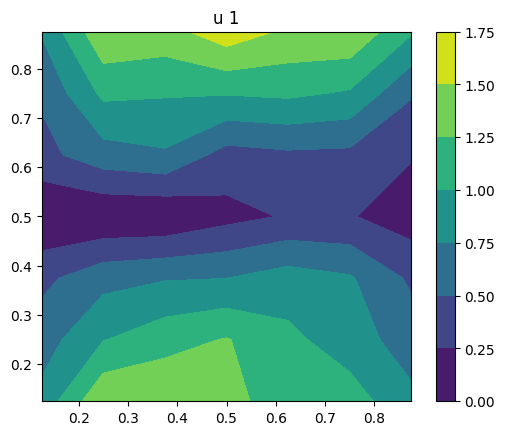

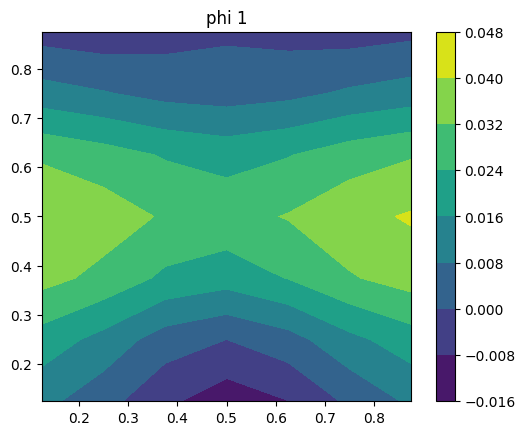

u_n vector: [[-0.83126287 -0.63181192 -0.43666833 -0.01101659  0.42401793  0.53743972
   0.76952261 -1.46939015 -0.98844643 -0.66309525 -0.01955196  0.64399831
   1.05318448  1.45907472 -1.4718381  -1.15451001 -0.73006189  0.01998456
   0.71679639  1.02252732  1.40109767 -1.3653565  -1.26482425 -0.74807833
  -0.16787969  0.40215911  1.01743918  1.65152025 -1.06135801 -1.06230444
  -0.86257657 -0.27175181  0.45431063  1.04918419  1.45418586 -1.11917016
  -0.86608808 -0.77786541 -0.26630918  0.43888906  0.97011082  1.46164221
  -0.80843279 -0.62847383 -0.45514696 -0.12148547  0.26828363  0.52447846
   1.02866385]
 [-1.07742245 -1.75844748 -2.0693563  -2.29151148 -2.10945237 -1.5203985
  -0.68062192 -0.75737508 -1.06949588 -1.26879866 -1.3483028  -1.25678477
  -1.07079907 -0.74655634 -0.28393371 -0.29399696 -0.46160289 -0.42489532
  -0.59273111 -0.67916264 -0.69624915  0.17192778  0.29720696  0.31342348
   0.1797123  -0.02044437 -0.02452723 -0.0089728   0.38653902  0.50583088
   0.6829702

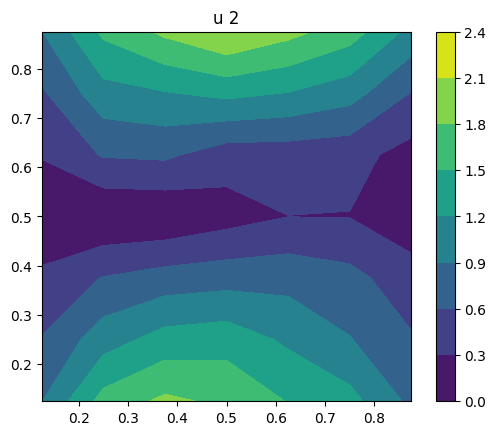

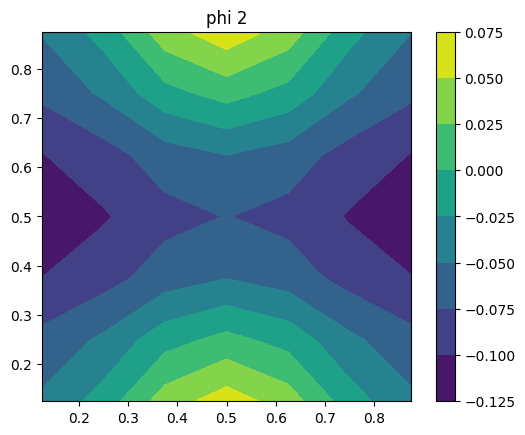

u_n vector: [[-0.88862002 -0.61616225 -0.37456857 -0.0036135   0.32310771  0.5544049
   0.88801962 -1.61413212 -1.06401317 -0.61314995 -0.02043289  0.62451874
   1.08812796  1.56107271 -1.86180161 -1.3211892  -0.72819247  0.03325591
   0.6541092   1.18042414  1.86375498 -1.7386296  -1.37998194 -0.77933854
  -0.17333539  0.43535088  1.27772852  2.11392839 -1.48615212 -1.14549491
  -0.7963636  -0.29740433  0.43096627  1.18821654  1.89612958 -1.30083645
  -0.91457643 -0.69309474 -0.29043469  0.40093519  1.02121385  1.64006033
  -0.82827944 -0.63115541 -0.41884162 -0.12383611  0.19030815  0.58508808
   1.10784408]
 [-1.01393881 -1.76891441 -2.10869588 -2.37425946 -2.21005365 -1.50218087
  -0.69624523 -0.60422718 -1.02039902 -1.30765384 -1.36947334 -1.26968915
  -1.04601054 -0.64924845 -0.15001166 -0.25616096 -0.46023686 -0.41583993
  -0.61378927 -0.6124039  -0.43179894  0.13455388  0.27164862  0.30972901
   0.2023793  -0.02014349 -0.02201415 -0.01266849  0.25548945  0.47707349
   0.7157093

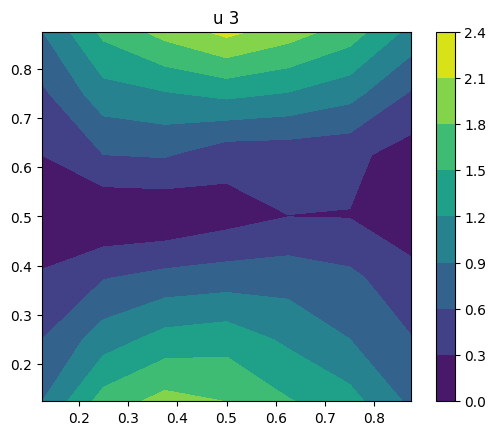

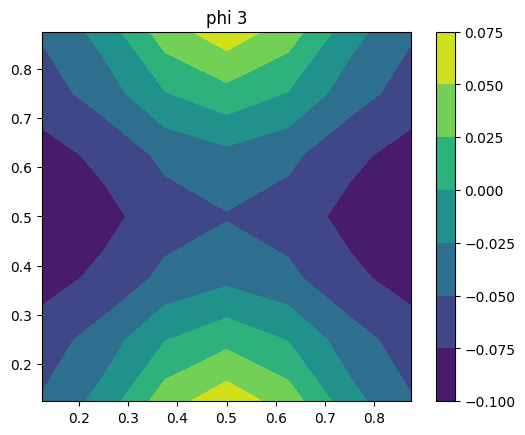

u_n vector: [[-8.90413634e-01 -5.99627542e-01 -3.47800344e-01 -2.14647978e-03
   2.99597028e-01  5.36490413e-01  8.84619094e-01 -1.62952800e+00
  -1.05076595e+00 -5.85685141e-01 -1.95923921e-02  5.97559211e-01
   1.07453440e+00  1.57395569e+00 -1.90284244e+00 -1.31768820e+00
  -7.00459452e-01  3.30019830e-02  6.27301034e-01  1.17717724e+00
   1.90674386e+00 -1.79463972e+00 -1.38466988e+00 -7.52541096e-01
  -1.73516251e-01  4.07123747e-01  1.28160859e+00  2.18084270e+00
  -1.52199197e+00 -1.14386737e+00 -7.71649353e-01 -2.96858951e-01
   4.03453736e-01  1.18610623e+00  1.94206839e+00 -1.31184929e+00
  -9.02158307e-01 -6.68295127e-01 -2.89387034e-01  3.73930917e-01
   1.00752421e+00  1.65426649e+00 -8.28520850e-01 -6.14355311e-01
  -3.93182390e-01 -1.22787984e-01  1.65400407e-01  5.65629265e-01
   1.10670320e+00]
 [-1.01529033e+00 -1.77534038e+00 -2.11564816e+00 -2.38017768e+00
  -2.21733474e+00 -1.51142327e+00 -6.98637218e-01 -5.97631855e-01
  -1.02651166e+00 -1.31608287e+00 -1.37824529

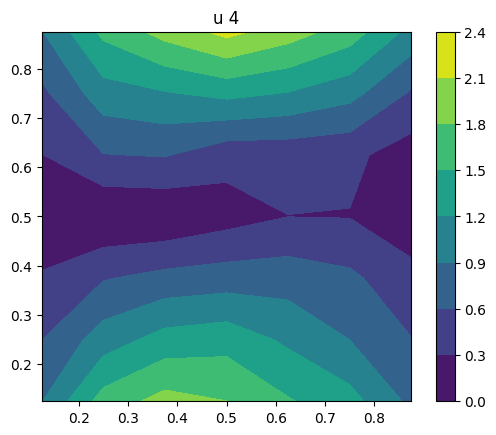

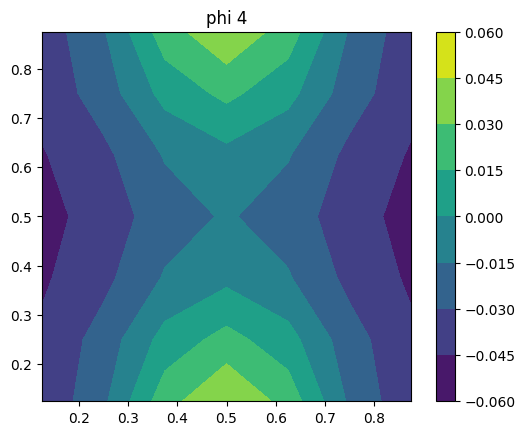

u_n vector: [[-8.87915782e-01 -5.93996199e-01 -3.40572216e-01 -2.28923989e-03
   2.91996900e-01  5.30937269e-01  8.82556185e-01 -1.62865650e+00
  -1.04643221e+00 -5.78430797e-01 -1.97098381e-02  5.90265474e-01
   1.07012338e+00  1.57320839e+00 -1.90724693e+00 -1.31662005e+00
  -6.93871521e-01  3.30182093e-02  6.20458165e-01  1.17617825e+00
   1.91128658e+00 -1.80244490e+00 -1.38551725e+00 -7.46583728e-01
  -1.73552480e-01  4.01211832e-01  1.28287740e+00  2.18811306e+00
  -1.52691678e+00 -1.14252701e+00 -7.64733347e-01 -2.97001968e-01
   3.96757542e-01  1.18493824e+00  1.94639773e+00 -1.31127655e+00
  -8.97716712e-01 -6.60778790e-01 -2.89522317e-01  3.66635269e-01
   1.00314545e+00  1.65360714e+00 -8.25954633e-01 -6.08766541e-01
  -3.85899106e-01 -1.22832175e-01  1.57975544e-01  5.60329188e-01
   1.10444326e+00]
 [-1.01749626e+00 -1.77832384e+00 -2.11892928e+00 -2.38344214e+00
  -2.22068806e+00 -1.51419121e+00 -7.01011836e-01 -5.98463832e-01
  -1.02970571e+00 -1.32064786e+00 -1.38270739

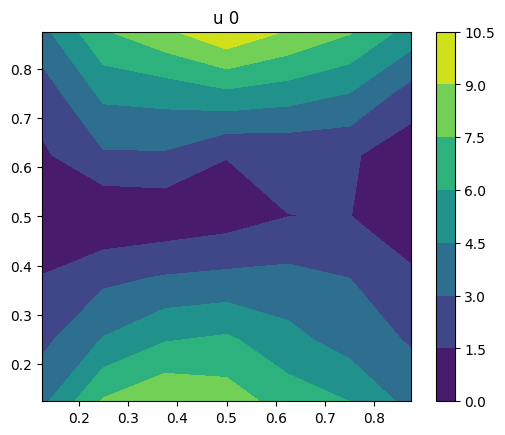

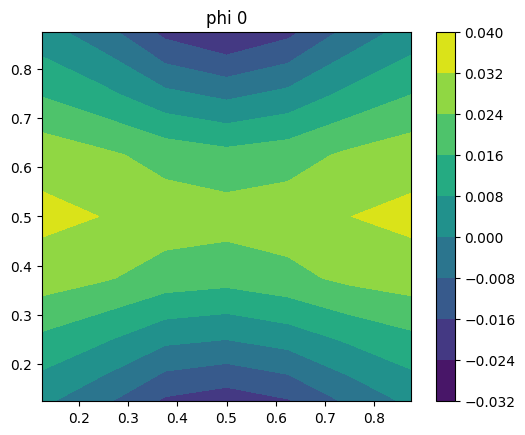

i 1
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


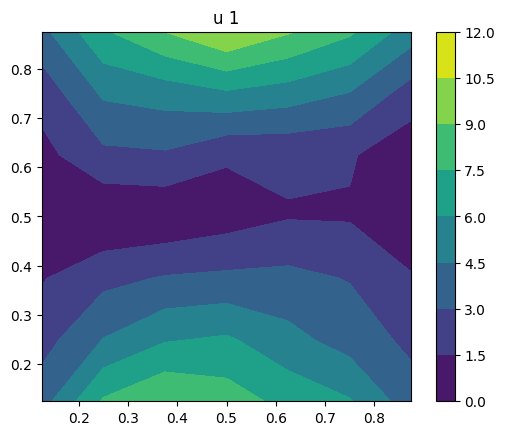

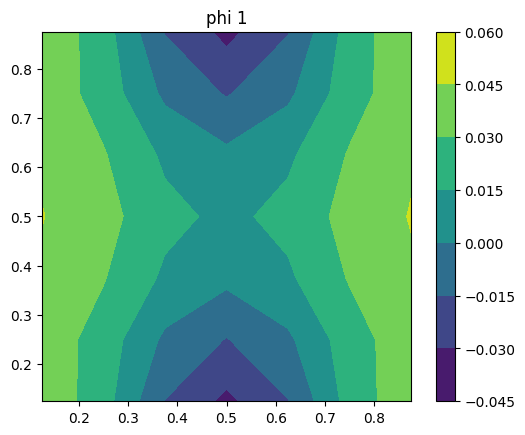

i 2
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


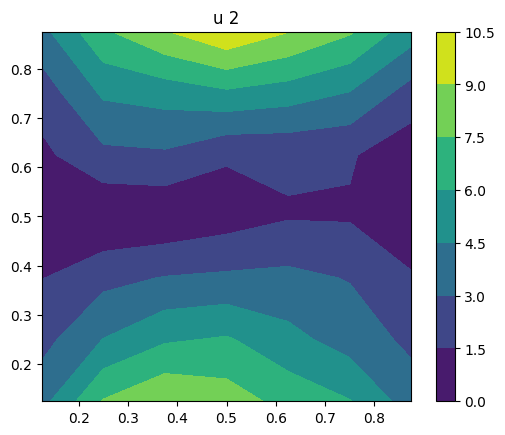

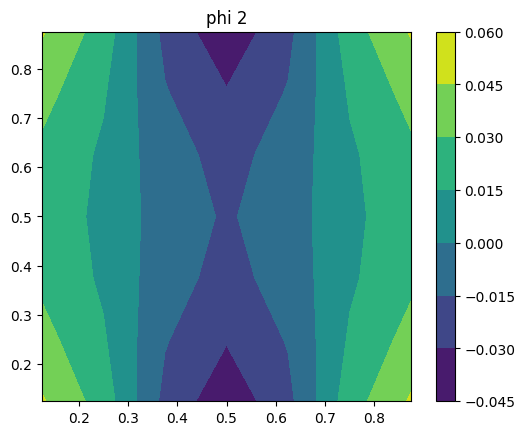

i 3
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


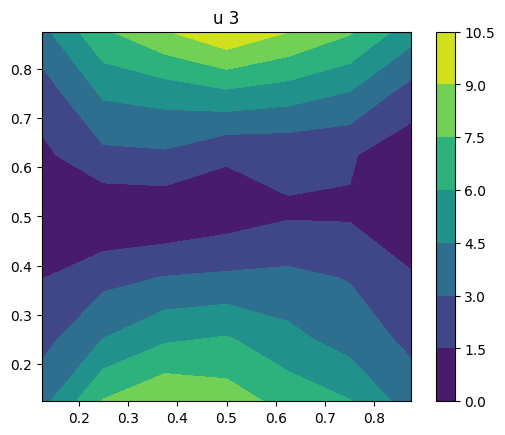

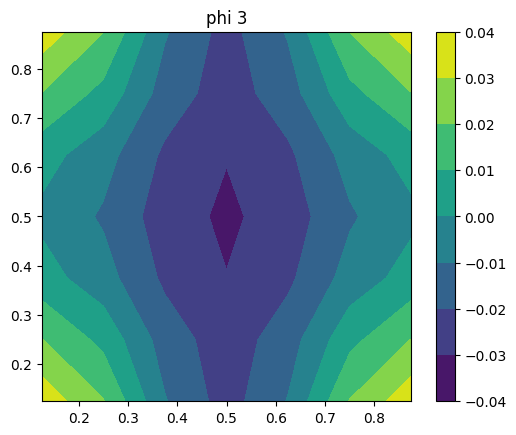

i 4
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


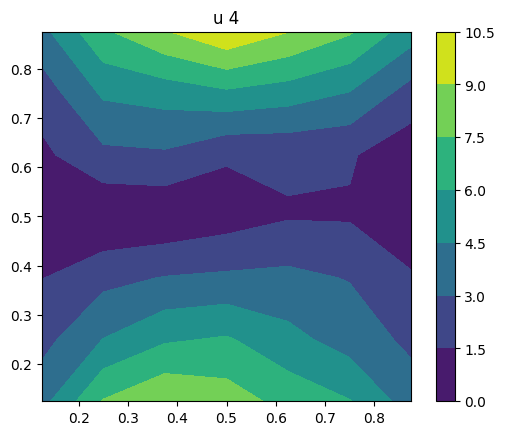

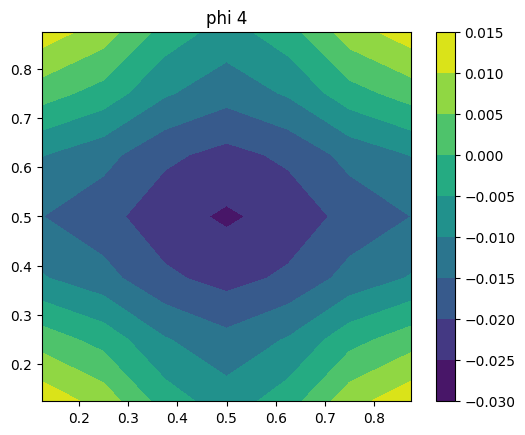

i 5
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


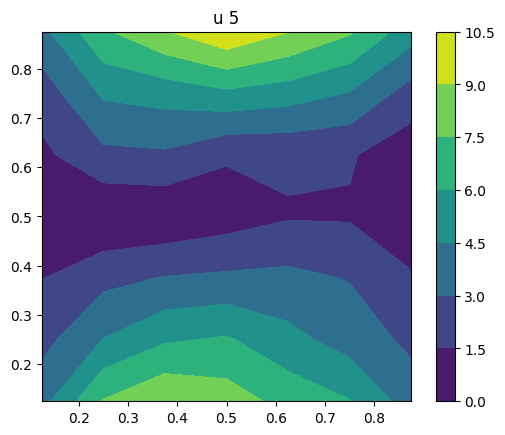

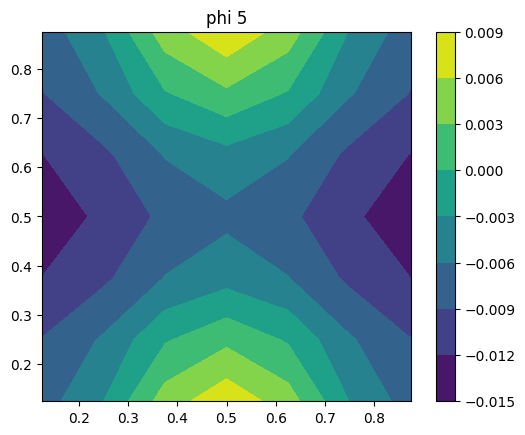

i 6
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


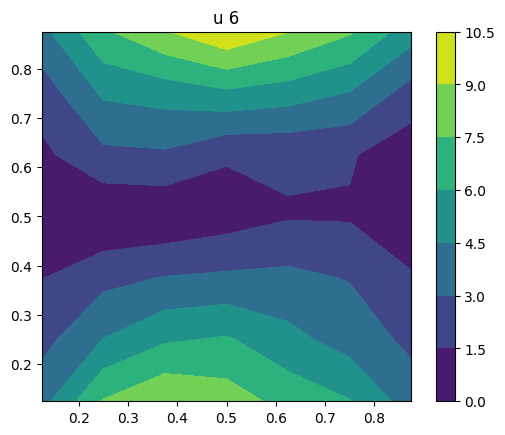

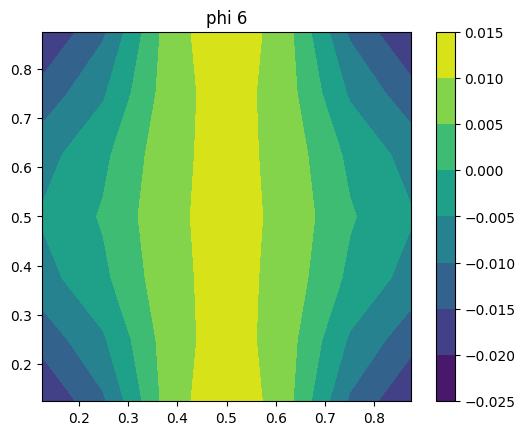

i 7
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


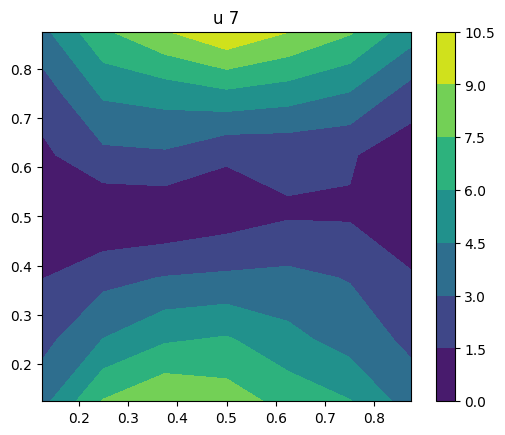

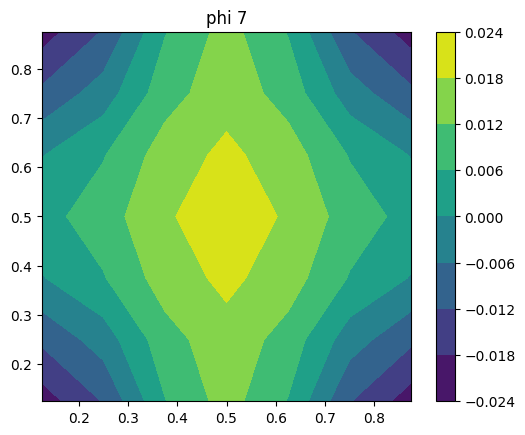

i 8
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


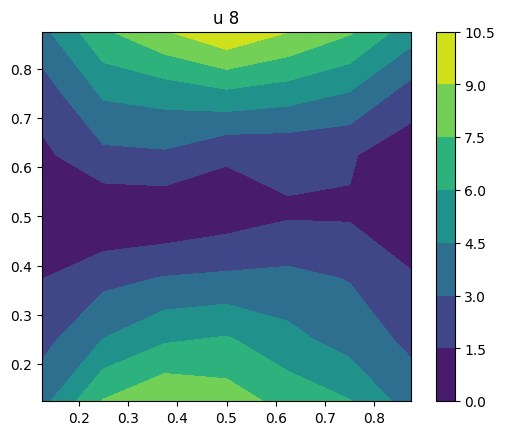

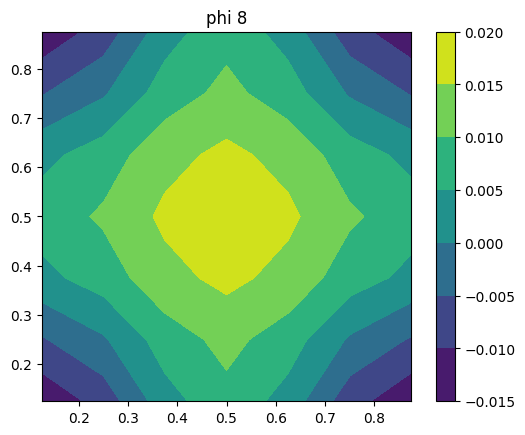

i 9
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


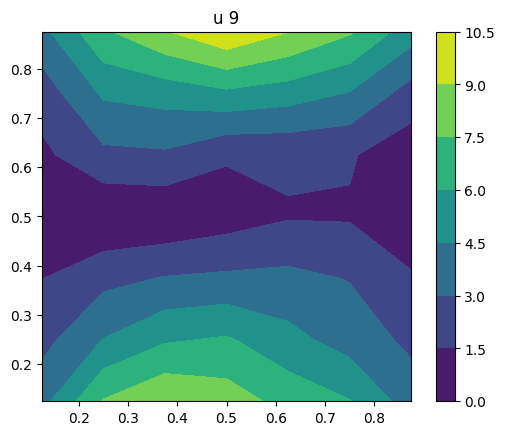

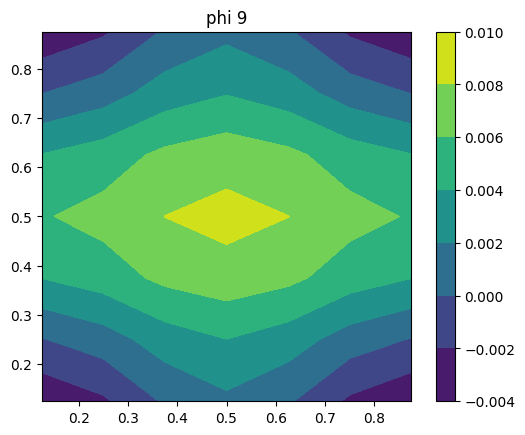

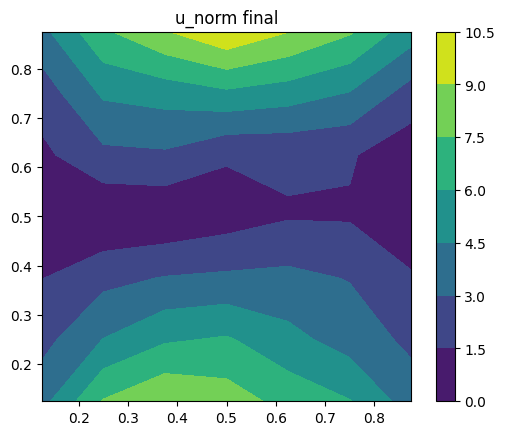

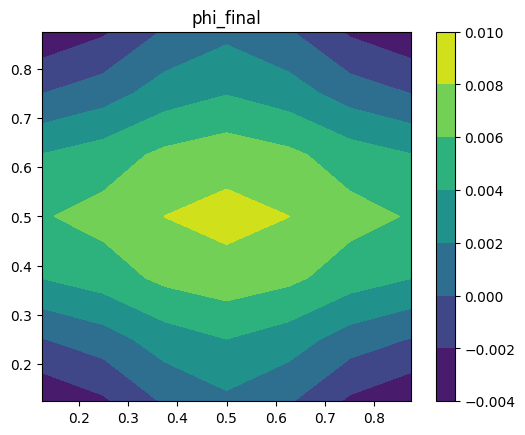

In [34]:
plotting(m-1, delta_x, delta_t, t_e, T, x_mod, y_mod, eta, rho, epsilon, M, C0)